# Sound Classifier Project

## Deep underground pipes can be hard to monitor and being left unattended may cause serious incidents. However, these pipes produce distinct sounds based on the health of the pipes. The sound produced by the pipes can be captured with micro-sound sensors installed near them. 

## This sound data can processed and then be fed to train a model using deep learning to classify and predict whether the pipe is healthy or not. Should the pipe be unhealthy/having problems, the model can classify it and inform the relevant stakeholders for necessary actions.

## In addition, predictive maintenance can be possible to prolong the longevity of the pipes.

## This project builds a binary classifier for sound data by training a neural network to solve the problem.

In [1]:
!pip install tensorflow tensorflow-io matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 30.0 MB/s eta 0:00:00


In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [4]:
!unzip -q Leak_Sound.zip -d ../

In [5]:
!unzip -q Non_Leak_Sound.zip -d ../

In [6]:
!unzip -q Test_Sound.zip -d ../

In [15]:
leak_file = '/Leak Sound/Leak_1.wav'
non_leak_file = '/Non_Leak Sound/Non_Leak_1.wav'


In [11]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [16]:
badwave = load_wav_16k_mono(leak_file)
goodwave = load_wav_16k_mono(non_leak_file)

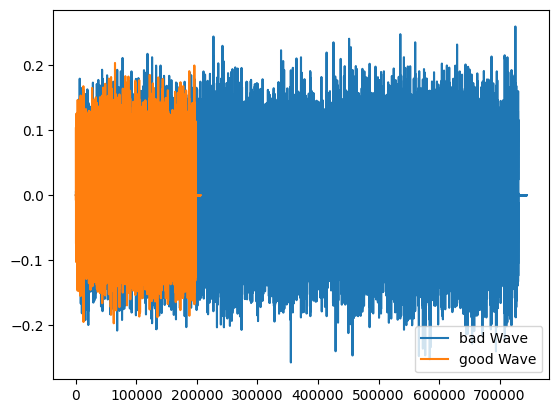

In [17]:
# Visualize the waveforms between a good (non-leak) and a bad (leak) sound
plt.plot(badwave, label='bad Wave')
plt.plot(goodwave, label='good Wave')
plt.legend(loc='lower right')
plt.show()

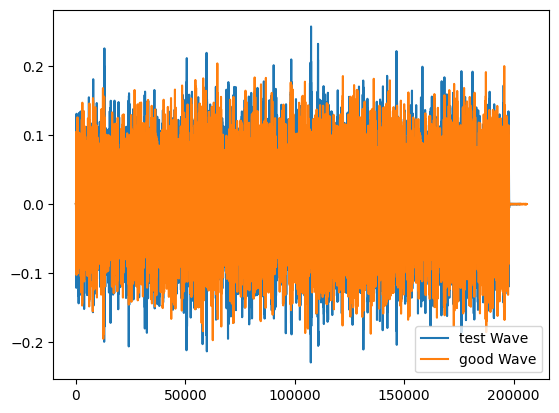

In [19]:
# Visualize waveform between a good and the test sound provided
test_file = '/Test Data/test_1.wav'
testwave = load_wav_16k_mono(test_file)
plt.plot(testwave, label='test Wave')
plt.plot(goodwave, label='good Wave')
plt.legend(loc='lower right')
plt.show()
# From this plot can tell that the testwave in blue is actually a bad (leak) wave

In [25]:
POS = '/Leak Sound'
NEG = '/Non_Leak Sound'
TEST = '/Test Data'

In [29]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')
test = tf.data.Dataset.list_files(TEST+'/*.wav')

In [30]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
tests = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos))))) 
data = positives.concatenate(negatives)
data = data.concatenate(tests) # The test data is located at the last index of the dataset
# For good sound = 0
# For bad sound = 1
# So the label elements in the dataset should look like [1,1,0,0,0,1]

In [31]:
num_elements = tf.data.experimental.cardinality(data).numpy()
num_elements
# However, we have 7 elements instead of 6. There is a bug whereby the first index repeats itself by concatenating at the back
# So now the label elements in the dataset look like [1,1,0,0,0,1,1] where the last index is a repeated of the first

7

In [32]:
# To solve this, we drop the last element. Then we check the number of elements again, should return 6 this time
data = data.repeat().take(len(data) - 1) 
num_elements = tf.data.experimental.cardinality(data).numpy()
num_elements

6

In [33]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:32000] 
    # Since the sound (good/bad) appears throughout the whole track, I can just take only the first 2s of the track
    # 32000 time steps divided by 16000Hz = 2s
    # This will save computational resource without sacrificing model performance since the region of interest is captured
    zero_padding = tf.zeros([32000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=120, frame_step=12)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
# Shuffling the data could potentially improve model performance by removing biases and it is a good practice to shuffle
# However, I choose not to shuffle the data because I want to preserve the last element of the dataset as the test data
# Anyway, the model has relatively good performance without shuffling
# Thus, I did not shuffle but not running this code below

# filepath, label = positives.shuffle(buffer_size=5).as_numpy_iterator().next()

In [34]:
filepath, label = positives.as_numpy_iterator().next() # This doesnt shuffle the data

In [35]:
spectrogram, label = preprocess(filepath, label)

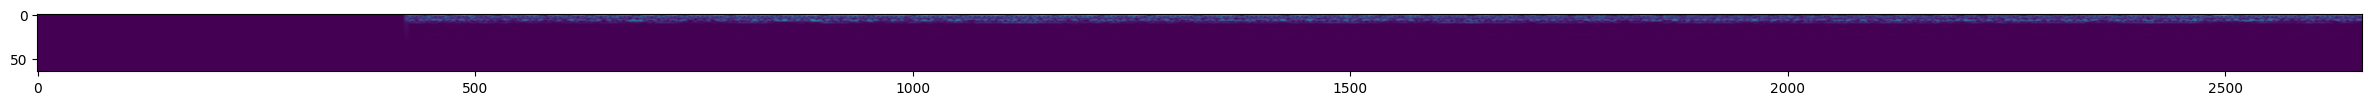

In [36]:
# Can barely see anything in this spectogram but I guess it works for the CNN later on
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [37]:
data = data.map(preprocess)
data = data.cache()
# data = data.shuffle(buffer_size=5) # This line is commented out to prevent shuffling of data
data = data.batch(8)
data = data.prefetch(4)

In [38]:
train = data.take(4) # First 4 data or clips are for training
# The training is considered a balanced dataset since first 2 clips are leak and next 2 clips are non-leak

val = data.skip(4).take(1) # 5th data or clip (non-leak) for validation
test = data.skip(5).take(1) # last data or clip which is the test clip provided for model prediction testing

In [39]:
samples, labels = train.as_numpy_iterator().next()

In [40]:
samples.shape

(6, 2657, 65, 1)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [42]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(2657, 65,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [43]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2655, 63, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 2653, 61, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 2589328)           0         
                                                                 
 dense (Dense)               (None, 16)                41429264  
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 41,431,761
Trainable params: 41,431,761
Non-trainable params: 0
_________________________________________________________________


In [45]:
hist = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
1/1 [==============================] - 12s 12s/step - loss: 0.7027 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 0s 61ms/step - loss: 0.9038 - recall: 0.3333 - precision: 1.0000
Epoch 3/5
1/1 [==============================] - 0s 59ms/step - loss: 10.4781 - recall: 1.0000 - precision: 0.5000
Epoch 4/5
1/1 [==============================] - 0s 62ms/step - loss: 6.2962 - recall: 1.0000 - precision: 0.5000
Epoch 5/5
1/1 [==============================] - 0s 58ms/step - loss: 0.3925 - recall: 1.0000 - precision: 0.7500


In [46]:
X_test, y_test = train.as_numpy_iterator().next()

In [47]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 115ms/step


In [48]:
yhat
# The prediction result of the entire dataset is expected since the training achieved 100% Precision and Recall
# The first 2 data are correctly predicted as leak, shown by a probablity of 1
# The next 3 data are correctly predicted as non-leak, shown with very small probabilities in the nano range
# And finally the test data correctly predicted as leak, shown by a probability of 1
# Recall that we already know that the test clip is leak by visualizing the waveform earlier
# We can also confirm that the test clip is leak by playing the audio clip

array([[1.0000000e+00],
       [1.0000000e+00],
       [1.9782564e-09],
       [5.1879896e-09],
       [1.6193013e-06],
       [1.0000000e+00]], dtype=float32)

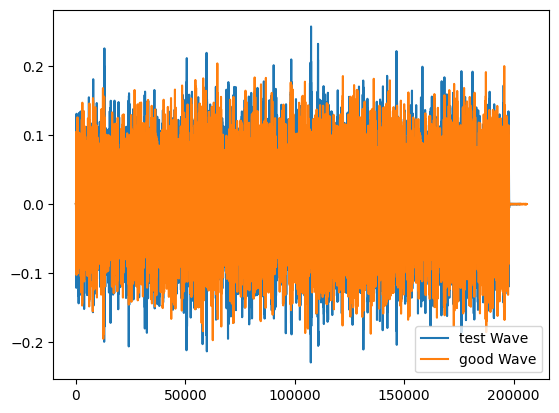

In [50]:
# Plotting this waveform again as reference
# Visualize waveform between a good and the test sound provided
test_file = '/Test Data/test_1.wav'
testwave = load_wav_16k_mono(test_file)
plt.plot(testwave, label='test Wave')
plt.plot(goodwave, label='good Wave')
plt.legend(loc='lower right')
plt.show()
# From this plot can tell that the testwave in blue is actually a bad (leak) wave